In [10]:
import pandas as pd
import src.etl as etl
import pymc as pm
import pytensor.tensor as pt
import arviz as az

In [2]:
raw_data = pd.read_csv("match_data.csv")

In [3]:
raw_data, encoders, model_dict, model_coords = etl.preprocess_data(input_df=raw_data, subset=True)

# Dumbest possible model

https://www.pymc.io/projects/examples/en/latest/case_studies/rugby_analytics.html

In [ ]:
with pm.Model(coords=model_coords) as model:

    #### Data

    home_team = pm.Data("home_team", model_dict["home_team_idx"], dims="matches")
    away_team = pm.Data("away_team", model_dict["away_team_idx"], dims="matches")
    league = pm.Data("league", model_dict["league_idx"], dims="matches")
    season = pm.Data("season", model_dict["season_idx"], dims="matches")
    home_score = pm.Data("home_score", model_dict["home_score"], dims="matches")
    away_score = pm.Data("away_score", model_dict["away_score"], dims="matches")

    #### Parameters

    intercept = pm.Normal("intercept", mu=1.3, sigma=1)
    home_adv = pm.Normal("home_adv", mu=0.2, sigma=0.5)

    league_ortg = pm.Normal("league_ortg", mu=0, sigma=1, dims="leagues")
    league_drtg = pm.Normal("league_drtg", mu=0, sigma=1, dims="leagues")

    sd_off = pm.HalfNormal("sd_off", sigma=2)
    sd_def = pm.HalfNormal("sd_def", sigma=2)
    ortg_raw = pm.Normal("ortg_raw", mu=0, sigma=sd_off, dims="teams")
    drtg_raw = pm.Normal("drtg_raw", mu=0, sigma=sd_def, dims="teams")

    # Zero-mean centering the team-level parameters
    ortg = pm.Deterministic("ortg", ortg_raw - pt.mean(ortg_raw), dims="teams")
    drtg = pm.Deterministic("drtg", drtg_raw - pt.mean(drtg_raw), dims="teams")

    #### Parameter Combinations
    home_theta = pt.exp(intercept + home_adv + ortg[home_team] + drtg[away_team])
    away_theta = pt.exp(intercept + ortg[away_team] + drtg[home_team])

    #### Observed Data
    home_points = pm.Poisson("home_points", mu=home_theta, observed=home_score, dims=("matches"))
    away_points = pm.Poisson("away_points", mu=away_theta, observed=away_score, dims=("matches"))

    trace = pm.sample(1000, tune=1500, cores=4)

INFO:/Users/bwieland/Desktop/Personal Work/efl-forecasting/.venv/lib/python3.12/site-packages/pytensor/link/c/lazylinker_c.py:Compiling new CVM
INFO:/Users/bwieland/Desktop/Personal Work/efl-forecasting/.venv/lib/python3.12/site-packages/pytensor/link/c/lazylinker_c.py:New version 0.212
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc.sampling.mcmc:NUTS: [intercept, home_adv, league_ortg, league_drtg, sd_off, sd_def, ortg_raw, drtg_raw]


/Users/bwieland/Desktop/Personal Work/efl-forecasting/.venv/lib/python3.12/site-packages/rich/live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

INFO:pymc.sampling.mcmc:Sampling 4 chains for 1_500 tune and 1_000 draw iterations (6_000 + 4_000 draws total) took 8 seconds.
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


<xarray.Dataset> Size: 7MB
Dimensions:      (chain: 4, draw: 1000, leagues: 2, teams: 52)
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * leagues      (leagues) <U14 112B 'Championship' 'Premier League'
  * teams        (teams) <U15 3kB 'Arsenal' 'Aston Villa' ... 'Wolves'
Data variables:
    intercept    (chain, draw) float64 32kB 0.1174 0.1296 ... 0.1397 0.1414
    home_adv     (chain, draw) float64 32kB 0.2126 0.202 ... 0.2101 0.2196
    league_ortg  (chain, draw, leagues) float64 64kB 0.5915 0.5901 ... 0.6623
    league_drtg  (chain, draw, leagues) float64 64kB 1.035 0.4874 ... -0.3223
    ortg_raw     (chain, draw, teams) float64 2MB 0.5407 0.4024 ... -0.01812
    drtg_raw     (chain, draw, teams) float64 2MB -0.5195 -0.2953 ... -0.02099
    sd_off       (chain, draw) float64 32kB 0.3213 0.3614 ... 0.3324 0.4188
    sd_def       (chain, draw) float64 32kB 0.2979 0.2767 ... 0.2729 0.2918
    ortg         (chain, draw, teams) float64 2MB 0.5766 0.4383 ... -0.02153
    drtg         (chain, draw, teams) float64 2MB -0.4797 -0.2555 ... 0.04591
Attributes:
    created_at:                 2024-11-08T21:28:03.527123+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.18.0
    sampling_time:              7.791584014892578
    tuning_steps:               1500

array([[<Axes: title={'center': 'ortg'}>,
        <Axes: title={'center': 'ortg'}>]], dtype=object)

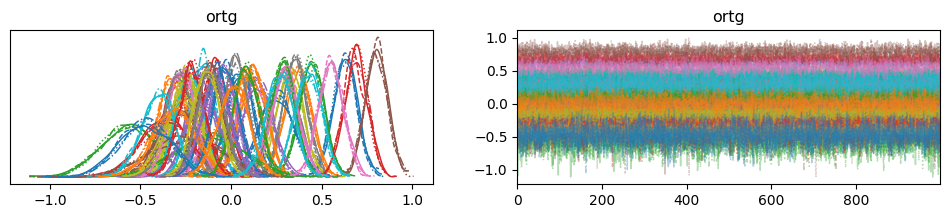

In [15]:
az.plot_trace(trace, var_names=["ortg"])

In [25]:
off_ratings = trace.posterior.ortg.mean(('chain', 'draw')).to_pandas()
def_ratings = trace.posterior.drtg.mean(('chain', 'draw')).to_pandas()

In [38]:
team_ratings = pd.DataFrame({"off_rating" : off_ratings, "def_rating" : def_ratings})
team_ratings["net_rating"] = team_ratings["off_rating"] - team_ratings["def_rating"]
team_ratings.sort_values("net_rating", inplace=True, ascending=False)

In [42]:
team_ratings.head(5)

,off_rating,def_rating,net_rating
teams,,,
Manchester City,0.803067,-0.635904,1.438971
Liverpool,0.688646,-0.525396,1.214042
Arsenal,0.629982,-0.464779,1.094761
Chelsea,0.444502,-0.324163,0.768664
Tottenham,0.551463,-0.208309,0.759772


In [43]:
team_ratings.tail(5)

,off_rating,def_rating,net_rating
teams,,,
Reading,-0.266535,0.371565,-0.638100
Wigan Athletic,-0.473514,0.189378,-0.662892
Rotherham Utd,-0.400335,0.316887,-0.717221
P'borough Utd,-0.365666,0.423916,-0.789583
Barnsley,-0.566069,0.266656,-0.832725
